# Q1
#### Read the data from the Eng_movies.txt.
#### Also remove the movies that fall within the 'adult' genre.

In [1]:
# Read all lines in the file.
filename = "Eng_movies.txt"
with open(filename, encoding="utf8") as f:
    movies = f.readlines()


# Take all movies that are not in the 'adult' genre because they could be offensive
all_movies = []
unique_genres = []
for movie in movies:
    number, title, genre, description = movie.split(" ::: ")
    
    # Append cleaned description instead of default description.
    if genre != 'adult':
        all_movies.append({"title": title, "genre": genre, "description": description})
        if genre not in unique_genres:
            unique_genres.append(genre)

# Print unique genres and number of movies.
print("Unique genres: ", unique_genres)
print()
print("Total Movies: ", len(all_movies))

Unique genres:  ['drama', 'thriller', 'documentary', 'comedy', 'crime', 'reality-tv', 'horror', 'sport', 'animation', 'action', 'fantasy', 'short', 'sci-fi', 'music', 'adventure', 'talk-show', 'western', 'family', 'mystery', 'history', 'news', 'biography', 'romance', 'game-show', 'musical', 'war']

Total Movies:  53252


### Since there are more than 10 labels, I will only keep 9 of them and put the rest within an "Other" label.
The labels I will keep are: drama, thriller, comedy, horror, action, western, romance, adventure, sci-fi, and finally other.

In [2]:
from collections import Counter
good_genres = ['drama', 'thriller', 'comedy', 'horror', 'action', 'western', 'romance', 'adventure', 'sci-fi', 'other']

for movie in all_movies:
    if movie['genre'] not in good_genres:
        movie['genre'] = 'other'
        
ct = Counter([movie['genre'] for movie in all_movies])
print("Each genre and the number of movies within that genre:")
for genre, count in ct.items():
    print(f"{genre}: {count}")

Each genre and the number of movies within that genre:
drama: 13493
thriller: 1585
other: 24232
comedy: 7307
horror: 2203
action: 1315
sci-fi: 646
adventure: 770
western: 1032
romance: 669


### Randomly sampling from data
As it can be seen from the Counter object, the data is now heavily inbalanced because there were a lot of movie genres that have been assigned to the "other" genre. Therefore, in order to keep a balance of the data I will select all the movies from the genres that have less than 1000 movies, namely "romance", "sci-fi", "adventure", and randomly sample 1000 movies from each of the other genres.

In [3]:
import random
random.seed(2023)

movies = []
movies_by_genre = {genre: [] for genre in good_genres}
for movie in all_movies:
    movies_by_genre[movie['genre']].append(movie)
    

for genre in movies_by_genre:
    if len(movies_by_genre[genre]) <= 1000:
        movies = movies + movies_by_genre[genre]
    else:
        movies = movies + random.sample(movies_by_genre[genre], 1000)
        
# Print sample size
print("Total number of movies in the sample: ", len(movies))

Total number of movies in the sample:  9085


#### For consistency reasons, I will use a random seed, namely 2023.
My dataset will consist of the 9085 movies randomly sampled above. \
Now I need to create lists with movie description and also the labels, and then create a training set, validation set and test set.

In [4]:
texts = []
labels = []
for movie in movies:
    texts.append(movie['description'])
    labels.append(movie['genre'])

#### Splitting the dataset into 60/20/20.

In [5]:
from sklearn import model_selection as model
texts_train_val, texts_test, labels_train_val, labels_test = model.train_test_split(texts, labels, 
                                                                test_size=0.2, random_state=42)
texts_train, texts_val, labels_train, labels_val = model.train_test_split(texts_train_val,
                                                                          labels_train_val, test_size=0.25,
                                                                          random_state = 42)

C:\Users\andre\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
print(f"{len(texts_train)=}\t{len(labels_train)=}")
print(f"{len(texts_val)=}\t{len(labels_val)=}")
print(f"{len(texts_test)=}\t{len(labels_test)=}")

len(texts_train)=5451	len(labels_train)=5451
len(texts_val)=1817	len(labels_val)=1817
len(texts_test)=1817	len(labels_test)=1817


In [7]:
total = len(movies)
print(f"{len(texts_train) / total} {len(texts_val) / total} {len(texts_test) / total}")

0.6 0.2 0.2


#### I have a perfect 60/20/20 split. Now onto printing the label counts for every split.

In [ ]:
# Function to print labels and their count for each of the splits
def print_label_counts(labels_split, name_split):
    print(f"Labels for {name_split}:")
    
    ct = Counter(labels_split)
    for _label, count in ct.items():
        print(f"{_label}: {count}")
    print()

In [ ]:
for name, _labels in {'Train': labels_train, 'Validation': labels_val, 'Test': labels_test}.items():
    print_label_counts(_labels, name)

Labels for Train:
thriller: 598
drama: 596
horror: 582
western: 611
comedy: 624
other: 580
action: 600
sci-fi: 389
romance: 387
adventure: 484

Labels for Validation:
horror: 217
thriller: 187
adventure: 139
romance: 138
sci-fi: 134
western: 193
comedy: 177
drama: 208
other: 215
action: 209

Labels for Test:
other: 205
horror: 201
adventure: 147
comedy: 199
action: 191
thriller: 215
romance: 144
drama: 196
western: 196
sci-fi: 123



# Q2 - K-means

#### Step 0: Preprocess the text with clean_text method and spaCy library, and then use TF-IDF vectorizer from sklearn to vectorize the text.

In [ ]:
import spacy
import re
from sklearn.feature_extraction.text import TfidfVectorizer
nlp = spacy.load('en_core_web_sm')

# Function to clean the text. Needed because the dataset is poorly written.
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower()
    
    return text

# Tokenizer function using spacy
def text_pipeline_spacy(text):
    tokens = []
    text = clean_text(text)
    doc = nlp(text)
    for t in doc:
        if not t.is_stop and not t.is_punct and not t.is_space:
            tokens.append(t.lemma_.lower())
    return tokens

vectorizer = TfidfVectorizer(tokenizer = text_pipeline_spacy)
vectorizer.fit(texts_train)

texts_train_vect = vectorizer.transform(texts_train)
texts_val_vect = vectorizer.transform(texts_val)

print(texts_train_vect.shape)
print(texts_val_vect.shape)

(5451, 27010)
(1817, 27010)


#### The vectorizer is fit only on the training split because later on I want to see how other models perform on 'unseen' data, namely the validation and test split. Therefore, the vocabulary size is 27040.

#### Step 1: Pick k random centroids method.

In [ ]:
# Make a new dictionary in order to keep track of each vector's assigned centroid.
texts_train_vect_dict = {i: {'vector':texts_train_vect[i]} for i in range(texts_train_vect.shape[0])}

def pick_centroids(vectors, k):
    ret = {}
    indices = random.sample([*range(len(vectors))], k)
    
    for i in range(k):
        ret[i] = vectors[indices[i]]['vector']
        
    return ret

#### Step 2: Assign each vector to its closest centroid method.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# I use cosine similarity from sklearn, rather than Euclidean distance, for better results.
def assign_vectors(vectors, centroids):
    for idx_vec in vectors:
        max_sim = -1
        for idx_cen in centroids:
            cos_sim = cosine_similarity(vectors[idx_vec]['vector'], centroids[idx_cen])
            if cos_sim > max_sim:
                max_sim = cos_sim
                vectors[idx_vec]['centroid'] = idx_cen

#### Step 3: Recalculate centroids method.

In [ ]:
# Step 3: Recalculate centroids
def recalc_centroids(vectors, centroids):
    centroids_counts = {i: {'count': 0} for i in range(len(centroids))}
    
    for vector in vectors.values():
        cen = vector['centroid']
        if 'sum' not in centroids_counts[cen]:
            centroids_counts[cen]['sum'] = vector['vector']
        else:
            centroids_counts[cen]['sum'] += vector['vector']
            
        centroids_counts[cen]['count'] += 1
            
    return {idx: centroids_counts[idx]['sum'] / centroids_counts[idx]['count'] for idx in range(len(centroids))}

#### Final step: implementing K-means by using all methods defined above.
Also defining one extra method for printing purposes.

In [ ]:
# Function that gets counts for every centroid.
def get_centroids_counts(vectors):
    return Counter([vector['centroid'] for vector in vectors.values()])

def Kmeans(vectors, k):
    centroids = pick_centroids(vectors, k)
    assign_vectors(vectors, centroids)
    
    diff = 1
    idx = 0
    while diff != 0:
        old_centroid_counts = get_centroids_counts(vectors)
        print(f"Iteration {idx + 1}:", old_centroid_counts)
        
        centroids = recalc_centroids(vectors, centroids)
        assign_vectors(vectors, centroids)
        
        new_centroid_counts = get_centroids_counts(vectors)
        
        # Check if there is still a difference in centroids' counts.
        diff = 0
        for i in range(k):
            diff += abs(new_centroid_counts[i] - old_centroid_counts[i])
        
        idx = idx + 1
        
    print("Final clusters: ", new_centroid_counts)
    
    return centroids
        
        
centroids = Kmeans(texts_train_vect_dict, 5)

Iteration 1: Counter({4: 1496, 1: 1455, 2: 1099, 0: 734, 3: 667})
Iteration 2: Counter({4: 1536, 1: 1506, 2: 1018, 0: 720, 3: 671})
Iteration 3: Counter({4: 1676, 1: 1520, 2: 978, 0: 653, 3: 624})
Iteration 4: Counter({4: 1763, 1: 1469, 2: 1025, 0: 598, 3: 596})
Iteration 5: Counter({4: 1794, 1: 1444, 2: 1042, 3: 593, 0: 578})
Iteration 6: Counter({4: 1797, 1: 1433, 2: 1054, 3: 595, 0: 572})
Iteration 7: Counter({4: 1801, 1: 1422, 2: 1054, 3: 597, 0: 577})
Iteration 8: Counter({4: 1805, 1: 1419, 2: 1058, 3: 596, 0: 573})
Iteration 9: Counter({4: 1809, 1: 1409, 2: 1061, 3: 596, 0: 576})
Iteration 10: Counter({4: 1812, 1: 1405, 2: 1062, 3: 597, 0: 575})
Iteration 11: Counter({4: 1812, 1: 1401, 2: 1066, 3: 597, 0: 575})
Iteration 12: Counter({4: 1818, 1: 1395, 2: 1068, 3: 597, 0: 573})
Iteration 13: Counter({4: 1819, 1: 1385, 2: 1068, 3: 598, 0: 581})
Iteration 14: Counter({4: 1819, 1: 1374, 2: 1069, 3: 598, 0: 591})
Iteration 15: Counter({4: 1820, 1: 1359, 2: 1068, 0: 604, 3: 600})
Itera

#### Choose 2 movies for each centroid, and also top 5 most representative tokens in each centroid.

In [ ]:
import numpy as np

# Get vocabulary
vocabulary = vectorizer.get_feature_names_out()

def get_top_tokens(centroid, vocabulary, k):
    most_freq_ind = np.argsort([centroid[0, i] for i in range(centroid.shape[1])] )[::-1]
    five_best = [vocabulary[most_freq_ind[i]] for i in range(5)]
    return five_best

def get_documents(centroid_idx, vectors, k):
    num = 0
    idx = 0
    while num < 2:
        if vectors[idx]['centroid'] == centroid_idx:
            
            # I know this is slow, but couldn't think of faster way
            # without re-writing the data structures.
            for movie in movies:
                if movie['description'] == texts_train[idx]:
                    title = movie['title']
            
            print(f"Movie {num+1}: \n Label: {labels_train[idx]} \n Title: {title}\n Description:{texts_train[idx]}")
            print()
            num += 1
        idx += 1
        
# Print tokens for each centroid and 2 movies
for j in range(5):
    five_best = get_top_tokens(centroids[j], vocabulary, 5)
    print(f"Centroid {j + 1}: ", five_best)
    get_documents(j, texts_train_vect_dict, 2)
    print("<------------------------------>")
    

C:\Users\andre\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Centroid 1:  ['world', 'earth', 'team', 'alien', 'human']
Movie 1: 
 Label: action 
 Title: Gallagher's Travels (1987)
 Description:When reporter Danny Gallagher and photographer Sally Woodrow team-up to crack an international animal smuggling racket, the gang behind the operation leads the reckless pair on a chase across Australia straight into the jaws of fatal danger.


Movie 2: 
 Label: action 
 Title: Rodina zhdyot (2003)
 Description:Somewhere in the Middle East, undercover agent Victor Bystroletov arrives in one of the oil kingdoms posing as an international journalist. His true goal is to contact a former terrorist named Javad. It has been several years since the holy warrior lay down his weapons and disappeared. Interpol is looking for him, as are his former jihad brothers, who have put a death sentence on his head for betrayal


<------------------------------>
Centroid 2:  ['film', 'story', 'movie', 'world', 'life']
Movie 1: 
 Label: comedy 
 Title: White Cargo (1973)
 Descr

#### Plot the confusion matrix for the train split.

In [40]:
import numpy as np
import seaborn as sn

def plotConfusionMatrix(cm, labels_x, labels_y):
    colour_map = sn.color_palette("Reds", as_cmap=True)
    
    plot = sn.heatmap(cm, 
                    annot=True, # Put the numbers in
                    annot_kws={"size": 16}, # Make the numbers bigger
                    fmt='g', # Stop scientific notation
                    cmap = colour_map, # Choose the colour palette
                    cbar = False, # Don't include the colour bar
                    xticklabels=labels_x, # Put in the X and Y labels
                    yticklabels=labels_y)

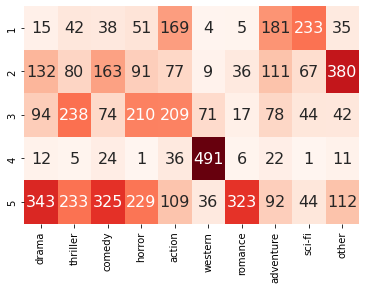

In [ ]:
labels_x = ['drama', 'thriller', 'comedy', 'horror', 'action', 'western', 'romance', 'adventure', 'sci-fi', 'other']
labels_y = ['1', '2', '3', '4', '5']

cm = np.zeros((5, 10))
for i in range(len(labels_train)):
    cm[texts_train_vect_dict[i]['centroid'], labels_x.index(labels_train[i])] += 1

plotConfusionMatrix(cm, labels_x, labels_y)

# Q3 - Comparing Classifiers

### (a)
#### For the validation set:

In [10]:
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.svm import SVC

#### Dummy classifier with strategy "most_frequent".

In [ ]:
# Fit clf on train and test on val
dummy_clf_freq = DummyClassifier(strategy="most_frequent")
dummy_clf_freq.fit(texts_train_vect,labels_train)
predictions = dummy_clf_freq.predict(texts_val_vect)

# Metrics
accuracy_dummy_clf_freq = accuracy_score(labels_val, predictions)
f1_dummy_clf_freq = f1_score(labels_val, predictions, average='macro')
precision_dummy_clf_freq = precision_score(labels_val, predictions, average='macro')
recall_dumy_clf_freq = recall_score(labels_val, predictions, average='macro')

print("Dummy classifier with strategy='most_frequent':")
print(f"Accuracy: {accuracy_dummy_clf_freq}")
print(f"Precision: {precision_dummy_clf_freq}")
print(f"Recall: {recall_dumy_clf_freq}")
print(f"F1 Score: {f1_dummy_clf_freq}")

Dummy classifier with strategy='most_frequent':
Accuracy: 0.09741331865712713
Precision: 0.009741331865712712
Recall: 0.1
F1 Score: 0.01775325977933801


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Dummy classifier with strategy "stratified".

In [ ]:
# Fit clf on train and test on val
dummy_clf_strat = DummyClassifier(strategy="stratified")
dummy_clf_strat.fit(texts_train_vect,labels_train)
predictions = dummy_clf_strat.predict(texts_val_vect)

# Metrics
accuracy_dummy_clf_strat = accuracy_score(labels_val, predictions)
f1_dummy_clf_strat = f1_score(labels_val, predictions, average='macro')
precision_dummy_clf_strat = precision_score(labels_val, predictions, average='macro')
recall_dummy_clf_strat = recall_score(labels_val, predictions, average='macro')

print("Dummy classifier with strategy='stratified':")
print(f"Accuracy: {accuracy_dummy_clf_strat}")
print(f"Precision: {precision_dummy_clf_strat}")
print(f"Recall: {recall_dummy_clf_strat}")
print(f"F1 Score: {f1_dummy_clf_strat}")

Dummy classifier with strategy='stratified':
Accuracy: 0.08805723720418272
Precision: 0.08521701757549713
Recall: 0.08495808778869034
F1 Score: 0.0849136503191141


#### Creating one-hot vectorization.

In [ ]:
count_vec = CountVectorizer(tokenizer = text_pipeline_spacy, token_pattern=u'(?u)\b\w*[a-zA-Z]\w*\b')
count_vec.fit(texts_train)

texts_train_vect_one = count_vec.transform(texts_train)
texts_val_vect_one = count_vec.transform(texts_val)

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
# Since count vectorizer actually computes frequency, I need to change everything to 1
texts_train_vect_one[texts_train_vect_one[:] > 0] = 1
texts_val_vect_one[texts_val_vect_one[:] > 0] = 1

#### Logistic regression with One-hot vectorization

In [ ]:
# Fit clf on train and test data
logistic_regression_one = LogisticRegression(max_iter=500)
lr_clf_one = logistic_regression_one.fit(texts_train_vect_one, labels_train)
predictions = lr_clf_one.predict(texts_val_vect_one)

# Metrics
accuracy_lr_one = accuracy_score(labels_val, predictions)
f1_lr_one = f1_score(labels_val, predictions, average='macro')
precision_lr_one = precision_score(labels_val, predictions, average='macro')
recall_lr_one = recall_score(labels_val, predictions, average='macro')

print("Logistic regression with One-hot vectorization:")
print(f"Accuracy: {accuracy_lr_one}")
print(f"Precision: {precision_lr_one}")
print(f"Recall: {recall_lr_one}")
print(f"F1 Score: {f1_lr_one}")

Logistic regression with One-hot vectorization:
Accuracy: 0.5338470005503577
Precision: 0.5418902364224442
Recall: 0.5299406110748355
F1 Score: 0.534691416081554


#### Logistic regression with TF-IDF vectorization.

In [ ]:
lr_clf_tfidf = logistic_regression_one.fit(texts_train_vect, labels_train)
predictions = lr_clf_tfidf.predict(texts_val_vect)

# Metrics
accuracy_lr_tfidf = accuracy_score(labels_val, predictions)
f1_lr_tfidf = f1_score(labels_val, predictions, average='macro')
precision_lr_tfidf = precision_score(labels_val, predictions, average='macro')
recall_lr_tfidf = recall_score(labels_val, predictions, average='macro')

print("Logistic regression with TF-IDF:")
print(f"Accuracy: {accuracy_lr_tfidf}")
print(f"Precision: {precision_lr_tfidf}")
print(f"Recall: {recall_lr_tfidf}")
print(f"F1 Score: {f1_lr_tfidf}")

Logistic regression with TF-IDF:
Accuracy: 0.5608145294441387
Precision: 0.5738037762741787
Recall: 0.549607860561738
F1 Score: 0.555218886974558


#### SVC with One-hot vectorization (SVM with RBF kernel)

In [ ]:
# Fit clf on train and test data
svc = SVC()
svc_clf = svc.fit(texts_train_vect_one, labels_train)
predictions = svc.predict(texts_val_vect_one)

# Metrics
accuracy_svc = accuracy_score(labels_val, predictions)
f1_svc = f1_score(labels_val, predictions, average='macro')
precision_svc = precision_score(labels_val, predictions, average='macro')
recall_svc = recall_score(labels_val, predictions, average='macro')

print("SVC with One-hot vectorization:")
print(f"Accuracy: {accuracy_svc}")
print(f"Precision: {precision_svc}")
print(f"Recall: {recall_svc}")
print(f"F1 Score: {f1_svc}")

SVC with One-hot vectorization:
Accuracy: 0.5107319757842598
Precision: 0.540661913349804
Recall: 0.49759924879335526
F1 Score: 0.5066283877917602


#### For the training set:

#### Dummy classifier with strategy "most_frequent".

In [ ]:
# Fit clf on train and test on val
dummy_clf_freq = DummyClassifier(strategy="most_frequent")
dummy_clf_freq.fit(texts_train_vect, labels_train)
predictions = dummy_clf_freq.predict(texts_train_vect)

# Metrics
accuracy_dummy_clf_freq = accuracy_score(labels_train, predictions)
f1_dummy_clf_freq = f1_score(labels_train, predictions, average='macro')
precision_dummy_clf_freq = precision_score(labels_train, predictions, average='macro')
recall_dumy_clf_freq = recall_score(labels_train, predictions, average='macro')

print("Dummy classifier with strategy='most_frequent':")
print(f"Accuracy: {accuracy_dummy_clf_freq}")
print(f"Precision: {precision_dummy_clf_freq}")
print(f"Recall: {recall_dumy_clf_freq}")
print(f"F1 Score: {f1_dummy_clf_freq}")

Dummy classifier with strategy='most_frequent':
Accuracy: 0.11447440836543754
Precision: 0.011447440836543754
Recall: 0.1
F1 Score: 0.020543209876543213


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Dummy classifier with strategy "stratified".

In [ ]:
# Fit clf on train and test on val
dummy_clf_strat = DummyClassifier(strategy="stratified")
dummy_clf_strat.fit(texts_train_vect,labels_train)
predictions = dummy_clf_strat.predict(texts_train_vect)

# Metrics
accuracy_dummy_clf_strat = accuracy_score(labels_train, predictions)
f1_dummy_clf_strat = f1_score(labels_train, predictions, average='macro')
precision_dummy_clf_strat = precision_score(labels_train, predictions, average='macro')
recall_dummy_clf_strat = recall_score(labels_train, predictions, average='macro')

print("Dummy classifier with strategy='stratified':")
print(f"Accuracy: {accuracy_dummy_clf_strat}")
print(f"Precision: {precision_dummy_clf_strat}")
print(f"Recall: {recall_dummy_clf_strat}")
print(f"F1 Score: {f1_dummy_clf_strat}")

Dummy classifier with strategy='stratified':
Accuracy: 0.10621904237754541
Precision: 0.10411827832912168
Recall: 0.10401814671173149
F1 Score: 0.10400405792155538


#### Logistic regression with One-hot vectorization

In [ ]:
# Fit clf on train and test data
logistic_regression_one = LogisticRegression(max_iter=500)
lr_clf_one = logistic_regression_one.fit(texts_train_vect_one, labels_train)
predictions = lr_clf_one.predict(texts_train_vect_one)

# Metrics
accuracy_lr_one = accuracy_score(labels_train, predictions)
f1_lr_one = f1_score(labels_train, predictions, average='macro')
precision_lr_one = precision_score(labels_train, predictions, average='macro')
recall_lr_one = recall_score(labels_train, predictions, average='macro')

print("Logistic regression with One-hot vectorization:")
print(f"Accuracy: {accuracy_lr_one}")
print(f"Precision: {precision_lr_one}")
print(f"Recall: {recall_lr_one}")
print(f"F1 Score: {f1_lr_one}")

Logistic regression with One-hot vectorization:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


#### Logistic regression with TF-IDF vectorization

In [ ]:
lr_clf_tfidf = logistic_regression_one.fit(texts_train_vect, labels_train)
predictions = lr_clf_tfidf.predict(texts_train_vect)

# Metrics
accuracy_lr_tfidf = accuracy_score(labels_train, predictions)
f1_lr_tfidf = f1_score(labels_train, predictions, average='macro')
precision_lr_tfidf = precision_score(labels_train, predictions, average='macro')
recall_lr_tfidf = recall_score(labels_train, predictions, average='macro')

print("Logistic regression with TF-IDF:")
print(f"Accuracy: {accuracy_lr_tfidf}")
print(f"Precision: {precision_lr_tfidf}")
print(f"Recall: {recall_lr_tfidf}")
print(f"F1 Score: {f1_lr_tfidf}")

Logistic regression with TF-IDF:
Accuracy: 0.9115758576407998
Precision: 0.9142118819696788
Recall: 0.9065041376529044
F1 Score: 0.9096018222305954


#### SVC with One-hot vectorization (SVM with RBF kernel).

In [ ]:
# Fit clf on train and test data
svc = SVC()
svc_clf = svc.fit(texts_train_vect_one, labels_train)
predictions = svc.predict(texts_train_vect_one)

# Metrics
accuracy_svc = accuracy_score(labels_train, predictions)
f1_svc = f1_score(labels_train, predictions, average='macro')
precision_svc = precision_score(labels_train, predictions, average='macro')
recall_svc = recall_score(labels_train, predictions, average='macro')

print("SVC with One-hot vectorization:")
print(f"Accuracy: {accuracy_svc}")
print(f"Precision: {precision_svc}")
print(f"Recall: {recall_svc}")
print(f"F1 Score: {f1_svc}")

SVC with One-hot vectorization:
Accuracy: 0.9532195927352779
Precision: 0.9542417434826211
Recall: 0.9507521172158828
F1 Score: 0.9522820725952847


#### Bar plot for Logistic Regression with TF-IDF.

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


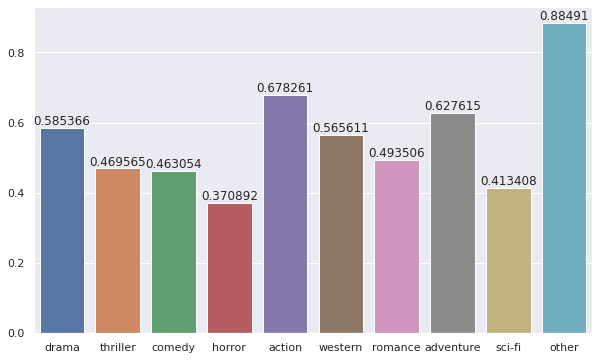

In [ ]:
import seaborn as sn
predictions = lr_clf_tfidf.predict(texts_val_vect)
f1_scores = f1_score(labels_val, predictions, average=None)

sn.set(rc={'figure.figsize':(10,6)})
ax = sn.barplot(good_genres, f1_scores)

for i in ax.containers:
    ax.bar_label(i,)

### (b)

#### Step 1 - new tokenization.
#### I tried removing proper nouns, adding numbers or doing both. Best result is achieved by just adding numbers.

In [ ]:
def clean_text_sec(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z0-9]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    
    return text

# Tokenizer function using spacy
def text_pipeline_spacy_sec(text):
    tokens = []
    text = clean_text_sec(text)
    doc = nlp(text)
    for t in doc:
        if not t.is_stop and not t.is_punct and not t.is_space:
            tokens.append(t.lemma_.lower())
    return tokens

#### Step 2 - set up vectorizer. Using TF-IDF because it yields better results.

In [ ]:
vectorizer_digits = TfidfVectorizer(tokenizer = text_pipeline_spacy_sec)
vectorizer_digits.fit(texts_train)

texts_train_vect_digits = vectorizer_digits.transform(texts_train)
texts_val_vect_digits = vectorizer_digits.transform(texts_val)

print(texts_train_vect_digits.shape)
print(texts_val_vect_digits.shape)

(5451, 27494)
(1817, 27494)


##### Step 3 - Experiment with different classifiers.

In [ ]:
lr_clf_tfidf = logistic_regression_one.fit(texts_train_vect_digits, labels_train)
predictions = lr_clf_tfidf.predict(texts_val_vect_digits)

# Metrics
accuracy_lr_tfidf = accuracy_score(labels_val, predictions)
f1_lr_tfidf = f1_score(labels_val, predictions, average='macro')
precision_lr_tfidf = precision_score(labels_val, predictions, average='macro')
recall_lr_tfidf = recall_score(labels_val, predictions, average='macro')

print("Logistic regression:")
print(f"Accuracy: {accuracy_lr_tfidf}")
print(f"Precision: {precision_lr_tfidf}")
print(f"Recall: {recall_lr_tfidf}")
print(f"F1 Score: {f1_lr_tfidf}")

Logistic regression:
Accuracy: 0.565767749036874
Precision: 0.5797848164025625
Recall: 0.5547082442108613
F1 Score: 0.5606379518671598


In [ ]:
# Fit clf on train and test data
svc = SVC()
svc_clf = svc.fit(texts_train_vect_digits, labels_train)
predictions = svc.predict(texts_val_vect_digits)

# Metrics
accuracy_svc = accuracy_score(labels_val, predictions)
f1_svc = f1_score(labels_val, predictions, average='macro')
precision_svc = precision_score(labels_val, predictions, average='macro')
recall_svc = recall_score(labels_val, predictions, average='macro')

print("SVC:")
print(f"Accuracy: {accuracy_svc}")
print(f"Precision: {precision_svc}")
print(f"Recall: {recall_svc}")
print(f"F1 Score: {f1_svc}")

SVC:
Accuracy: 0.5481563015960375
Precision: 0.598145879191195
Recall: 0.5306220220477373
F1 Score: 0.5437697088956505


In [ ]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(texts_train_vect_digits.toarray(), labels_train)
predictions = clf.predict(texts_val_vect_digits.toarray())

accuracy_nb = accuracy_score(labels_val, predictions)
f1_nb = f1_score(labels_val, predictions, average='macro')
precision_nb = precision_score(labels_val, predictions, average='macro')
recall_nb = recall_score(labels_val, predictions, average='macro')

print("Naive Bayes:")
print(f"Accuracy: {accuracy_nb}")
print(f"Precision: {precision_nb}")
print(f"Recall: {recall_nb}")
print(f"F1 Score: {f1_nb}")

Naive Bayes:
Accuracy: 0.35718216840946615
Precision: 0.3666320976627298
Recall: 0.35002306796639926
F1 Score: 0.3525952305478603


In [ ]:
# Fit clf on train and test data
svc = SVC(kernel='sigmoid')
svc_clf = svc.fit(texts_train_vect_digits, labels_train)
predictions = svc.predict(texts_val_vect_digits)

# Metrics
accuracy_svc = accuracy_score(labels_val, predictions)
f1_svc = f1_score(labels_val, predictions, average='macro')
precision_svc = precision_score(labels_val, predictions, average='macro')
recall_svc = recall_score(labels_val, predictions, average='macro')

print("SVC with sigmoid kernel:")
print(f"Accuracy: {accuracy_svc}")
print(f"Precision: {precision_svc}")
print(f"Recall: {recall_svc}")
print(f"F1 Score: {f1_svc}")

SVC with sigmoid kernel:
Accuracy: 0.5624656026417171
Precision: 0.5778217886919709
Recall: 0.5554335130911344
F1 Score: 0.5626567762722734


In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()

clf.fit(texts_train_vect_digits, labels_train)
predictions = clf.predict(texts_val_vect_digits)

# Metrics
accuracy_rf = accuracy_score(labels_val, predictions)
f1_rf = f1_score(labels_val, predictions, average='macro')
precision_rf = precision_score(labels_val, predictions, average='macro')
recall_rf = recall_score(labels_val, predictions, average='macro')

print("Random forests with digits:")
print(f"Accuracy: {accuracy_rf}")
print(f"Precision: {precision_rf}")
print(f"Recall: {recall_rf}")
print(f"F1 Score: {f1_rf}")

Random forests with digits:
Accuracy: 0.5118326912493121
Precision: 0.5091515000927725
Recall: 0.5025618563578194
F1 Score: 0.49797387170221974


/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


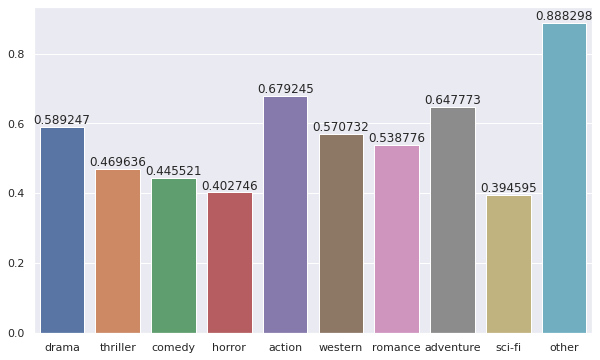

In [ ]:
import seaborn as sn
svc_clf = svc.fit(texts_train_vect_digits, labels_train)
predictions = svc.predict(texts_val_vect_digits)
f1_scores = f1_score(labels_val, predictions, average=None)

sn.set(rc={'figure.figsize':(10,6)})
ax = sn.barplot(good_genres, f1_scores)

for i in ax.containers:
    ax.bar_label(i,)

# Q4 - Parameter Tuning

### Tweaking the sublinear_tf

In [ ]:
vectorizer = TfidfVectorizer(tokenizer = text_pipeline_spacy, sublinear_tf=True)
vectorizer.fit(texts_train)

texts_train_vect = vectorizer.transform(texts_train)
texts_val_vect = vectorizer.transform(texts_val)

logistic_regression_one = LogisticRegression(max_iter=500)
lr_clf_tfidf = logistic_regression_one.fit(texts_train_vect, labels_train)
predictions = lr_clf_tfidf.predict(texts_val_vect)

# Metrics
accuracy_lr_tfidf = accuracy_score(labels_val, predictions)
f1_lr_tfidf = f1_score(labels_val, predictions, average='macro')
precision_lr_tfidf = precision_score(labels_val, predictions, average='macro')
recall_lr_tfidf = recall_score(labels_val, predictions, average='macro')

print("Logistic regression with TF-IDF:")
print(f"Accuracy: {accuracy_lr_tfidf}")
print(f"Precision: {precision_lr_tfidf}")
print(f"Recall: {recall_lr_tfidf}")
print(f"F1 Score: {f1_lr_tfidf}")

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Logistic regression with TF-IDF:
Accuracy: 0.5773252614199229
Precision: 0.5858973646760341
Recall: 0.5650133439614319
F1 Score: 0.569477193073868


### Tweaking the C value

In [ ]:
C_ranges = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]

max_f1 = 0
max_acc = 0
max_prec = 0
max_rec = 0
best_C = 0

for _C in C_ranges:
    logistic_regression_one = LogisticRegression(max_iter=500, C = _C)
    lr_clf_tfidf = logistic_regression_one.fit(texts_train_vect, labels_train)
    predictions = lr_clf_tfidf.predict(texts_val_vect)

    # Metrics
    accuracy_lr_tfidf = accuracy_score(labels_val, predictions)
    f1_lr_tfidf = f1_score(labels_val, predictions, average='macro')
    precision_lr_tfidf = precision_score(labels_val, predictions, average='macro')
    recall_lr_tfidf = recall_score(labels_val, predictions, average='macro')

    if f1_lr_tfidf > max_f1:
        max_f1 = f1_lr_tfidf
        max_acc = accuracy_lr_tfidf
        max_prec = precision_lr_tfidf
        max_rec = recall_lr_tfidf
        best_C = _C
    
    print(f"C={_C}, acc={accuracy_lr_tfidf}, F1={f1_lr_tfidf}, precision={precision_lr_tfidf}, recall={recall_lr_tfidf}")
    

print(f"Best C={best_C}: acc={max_acc}, F1={max_f1}, precision={max_prec}, recall={max_rec} ")

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


C=0.001, acc=0.09851403412217942, F1=0.01982236638863145, precision=0.10975206611570247, recall=0.10103626943005181


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


C=0.01, acc=0.21574023115024765, F1=0.1303911269790699, precision=0.2726597869600515, recall=0.2099399210992745


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


C=0.1, acc=0.4980737479361585, F1=0.4274421191956817, precision=0.5214797105706197, recall=0.45971290180240143
C=1, acc=0.5773252614199229, F1=0.569477193073868, precision=0.5858973646760341, recall=0.5650133439614319
C=10, acc=0.5740231150247661, F1=0.573813454330687, precision=0.5806745469722969, recall=0.5695467989614235
C=100, acc=0.5663181067694001, F1=0.5656474901260499, precision=0.5701284349656446, recall=0.5626450717253039
C=1000, acc=0.5613648871766649, F1=0.5603931128840649, precision=0.5639839717350237, recall=0.5582488597073865
C=10000, acc=0.5569620253164557, F1=0.5555691714430884, precision=0.5593791305785801, recall=0.5533695770859595
C=100000, acc=0.5531095211887727, F1=0.5517813821699826, precision=0.5547890537085918, recall=0.550084256542174
Best C=10: acc=0.5740231150247661, F1=0.573813454330687, precision=0.5806745469722969, recall=0.5695467989614235 


#### Tweaking the solver

In [ ]:
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

max_f1 = 0
max_acc = 0
max_prec = 0
max_rec = 0
best_solver = 0

for _solver in solvers:
    logistic_regression_one = LogisticRegression(max_iter=1000, solver=_solver)
    lr_clf_tfidf = logistic_regression_one.fit(texts_train_vect, labels_train)
    predictions = lr_clf_tfidf.predict(texts_val_vect)

    # Metrics
    accuracy_lr_tfidf = accuracy_score(labels_val, predictions)
    f1_lr_tfidf = f1_score(labels_val, predictions, average='macro')
    precision_lr_tfidf = precision_score(labels_val, predictions, average='macro')
    recall_lr_tfidf = recall_score(labels_val, predictions, average='macro')

    if f1_lr_tfidf > max_f1:
        max_f1 = f1_lr_tfidf
        max_acc = accuracy_lr_tfidf
        max_prec = precision_lr_tfidf
        max_rec = recall_lr_tfidf
        best_solver = _solver
    
    print(f"Solver={_solver}, acc={accuracy_lr_tfidf}, F1={f1_lr_tfidf}, precision={precision_lr_tfidf}, recall={recall_lr_tfidf}")
    

print(f"Best solver={best_solver}: acc={max_acc}, F1={max_f1}, precision={max_prec}, recall={max_rec} ")

Solver=newton-cg, acc=0.5773252614199229, F1=0.569477193073868, precision=0.5858973646760341, recall=0.5650133439614319
Solver=lbfgs, acc=0.5773252614199229, F1=0.569477193073868, precision=0.5858973646760341, recall=0.5650133439614319
Solver=liblinear, acc=0.5751238304898184, F1=0.56524459962729, precision=0.5825684578888282, recall=0.562100537192263
Solver=sag, acc=0.5773252614199229, F1=0.569477193073868, precision=0.5858973646760341, recall=0.5650133439614319
Solver=saga, acc=0.5773252614199229, F1=0.5696803267415369, precision=0.5859683018737443, recall=0.5651730098911788
Best solver=saga: acc=0.5773252614199229, F1=0.5696803267415369, precision=0.5859683018737443, recall=0.5651730098911788 


#### Trying all C values and solver values

In [ ]:

for _solver in solvers:
    for _C in C_ranges:
        logistic_regression_one = LogisticRegression(max_iter=1000, solver=_solver, C=_C)
        lr_clf_tfidf = logistic_regression_one.fit(texts_train_vect, labels_train)
        predictions = lr_clf_tfidf.predict(texts_val_vect)

        # Metrics
        accuracy_lr_tfidf = accuracy_score(labels_val, predictions)
        f1_lr_tfidf = f1_score(labels_val, predictions, average='macro')
        precision_lr_tfidf = precision_score(labels_val, predictions, average='macro')
        recall_lr_tfidf = recall_score(labels_val, predictions, average='macro')

        if f1_lr_tfidf > max_f1:
            max_f1 = f1_lr_tfidf
            max_acc = accuracy_lr_tfidf
            max_prec = precision_lr_tfidf
            max_rec = recall_lr_tfidf
            best_solver = _solver
            best_C = _C

        print(f"Solver={_solver} and C={_C}, acc={accuracy_lr_tfidf}, F1={f1_lr_tfidf}, precision={precision_lr_tfidf}, recall={recall_lr_tfidf}")
    

print(f"Best solver={best_solver}, Best C={best_C}: acc={max_acc}, F1={max_f1}, precision={max_prec}, recall={max_rec} ")

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Solver=newton-cg and C=0.001, acc=0.09851403412217942, F1=0.01982236638863145, precision=0.10975206611570247, recall=0.10103626943005181


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Solver=newton-cg and C=0.01, acc=0.21574023115024765, F1=0.1303911269790699, precision=0.2726597869600515, recall=0.2099399210992745


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Solver=newton-cg and C=0.1, acc=0.4980737479361585, F1=0.4275069612467675, precision=0.5216237651755764, recall=0.45971290180240143
Solver=newton-cg and C=1, acc=0.5773252614199229, F1=0.569477193073868, precision=0.5858973646760341, recall=0.5650133439614319
Solver=newton-cg and C=10, acc=0.5745734727572922, F1=0.574404736590681, precision=0.5814464446584637, recall=0.570025267860945
Solver=newton-cg and C=100, acc=0.5663181067694001, F1=0.5656474901260499, precision=0.5701284349656446, recall=0.5626450717253039
Solver=newton-cg and C=1000, acc=0.561915244909191, F1=0.5608183834657253, precision=0.5643705418339702, recall=0.558709689200474
Solver=newton-cg and C=10000, acc=0.5569620253164557, F1=0.5556801249539294, precision=0.5595767567299219, recall=0.55335392413426
Solver=newton-cg and C=100000, acc=0.5531095211887727, F1=0.551932934984299, precision=0.5552047636289426, recall=0.5500279660834068


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Solver=lbfgs and C=0.001, acc=0.09851403412217942, F1=0.01982236638863145, precision=0.10975206611570247, recall=0.10103626943005181


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Solver=lbfgs and C=0.01, acc=0.21574023115024765, F1=0.1303911269790699, precision=0.2726597869600515, recall=0.2099399210992745


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Solver=lbfgs and C=0.1, acc=0.4980737479361585, F1=0.4274421191956817, precision=0.5214797105706197, recall=0.45971290180240143
Solver=lbfgs and C=1, acc=0.5773252614199229, F1=0.569477193073868, precision=0.5858973646760341, recall=0.5650133439614319
Solver=lbfgs and C=10, acc=0.5740231150247661, F1=0.573813454330687, precision=0.5806745469722969, recall=0.5695467989614235
Solver=lbfgs and C=100, acc=0.5663181067694001, F1=0.5656474901260499, precision=0.5701284349656446, recall=0.5626450717253039
Solver=lbfgs and C=1000, acc=0.5613648871766649, F1=0.5603931128840649, precision=0.5639839717350237, recall=0.5582488597073865
Solver=lbfgs and C=10000, acc=0.5569620253164557, F1=0.5555691714430884, precision=0.5593791305785801, recall=0.5533695770859595
Solver=lbfgs and C=100000, acc=0.5531095211887727, F1=0.5517813821699826, precision=0.5547890537085918, recall=0.550084256542174


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Solver=liblinear and C=0.001, acc=0.17721518987341772, F1=0.10102768976443037, precision=0.09967169816888731, recall=0.17508269664236997


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Solver=liblinear and C=0.01, acc=0.2526141992294992, F1=0.17715027373890263, precision=0.3882103745142016, recall=0.24216860683590208


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Solver=liblinear and C=0.1, acc=0.4964226747385801, F1=0.42402547953597935, precision=0.5233086268112064, recall=0.4580458877478385
Solver=liblinear and C=1, acc=0.5751238304898184, F1=0.56524459962729, precision=0.5825684578888282, recall=0.562100537192263
Solver=liblinear and C=10, acc=0.57347275729224, F1=0.5706534823929983, precision=0.5752952276030443, recall=0.5685851357206704
Solver=liblinear and C=100, acc=0.5608145294441387, F1=0.5590052775522356, precision=0.5623312565790599, recall=0.5572799089239764
Solver=liblinear and C=1000, acc=0.5547605943863512, F1=0.5524296436286686, precision=0.5549593308990429, recall=0.5512297779781588
Solver=liblinear and C=10000, acc=0.5547605943863512, F1=0.5529383294821935, precision=0.5547800070702996, recall=0.5523743459359709
Solver=liblinear and C=100000, acc=0.5509080902586682, F1=0.5494594090784231, precision=0.5510540984498734, recall=0.5489829054347668


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Solver=sag and C=0.001, acc=0.09851403412217942, F1=0.01982236638863145, precision=0.10975206611570247, recall=0.10103626943005181


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Solver=sag and C=0.01, acc=0.21574023115024765, F1=0.13067963756188825, precision=0.2730663407100003, recall=0.2099399210992745


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Solver=sag and C=0.1, acc=0.4980737479361585, F1=0.4275069612467675, precision=0.5216237651755764, recall=0.45971290180240143
Solver=sag and C=1, acc=0.5773252614199229, F1=0.569477193073868, precision=0.5858973646760341, recall=0.5650133439614319
Solver=sag and C=10, acc=0.5740231150247661, F1=0.573813454330687, precision=0.5806745469722969, recall=0.5695467989614235
Solver=sag and C=100, acc=0.5663181067694001, F1=0.5656627132006802, precision=0.5702582470936797, recall=0.5625608692046605
Solver=sag and C=1000, acc=0.5630159603742433, F1=0.5617659350404474, precision=0.5655927647325514, recall=0.5595107870993181
Solver=sag and C=10000, acc=0.5635663181067694, F1=0.5613058755276319, precision=0.5637994959967222, recall=0.559753741315046
Solver=sag and C=100000, acc=0.5586130985140341, F1=0.5567345662427574, precision=0.5580351774459238, recall=0.5562450653154685


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Solver=saga and C=0.001, acc=0.09851403412217942, F1=0.01982236638863145, precision=0.10975206611570247, recall=0.10103626943005181


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Solver=saga and C=0.01, acc=0.21574023115024765, F1=0.13016724678807412, precision=0.2741003366003366, recall=0.2099399210992745


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Solver=saga and C=0.1, acc=0.4980737479361585, F1=0.4274421191956817, precision=0.5214797105706197, recall=0.45971290180240143
Solver=saga and C=1, acc=0.5773252614199229, F1=0.5696803267415369, precision=0.5859683018737443, recall=0.5651730098911788
Solver=saga and C=10, acc=0.57347275729224, F1=0.5729291854332138, precision=0.5795970819058114, recall=0.5687408716491009
Solver=saga and C=100, acc=0.5652173913043478, F1=0.5647801554768851, precision=0.5693725548664795, recall=0.5616192704808038
Solver=saga and C=1000, acc=0.5652173913043478, F1=0.5643847032447875, precision=0.5668861283422083, recall=0.5627945523853118
Solver=saga and C=10000, acc=0.5635663181067694, F1=0.5621784873364672, precision=0.564522427646265, recall=0.5608742442092229
Solver=saga and C=100000, acc=0.5635663181067694, F1=0.5624358844696199, precision=0.5657759840693537, recall=0.5604206371179321
Best solver=newton-cg, Best C=10: acc=0.5745734727572922, F1=0.574404736590681, precision=0.5814464446584637, recall=

#### So far, judging by macro F1 value, best C value = 10 and the best solver is newton_cg. What's interesting is that multiple solvers give the same F1 value when C=1.

#### Now tweaking max_features of vectorizer and testing on logistic regression with C=1 and solver = newton-cg

#### For max_features = 25k

In [ ]:
vectorizer = TfidfVectorizer(tokenizer = text_pipeline_spacy, sublinear_tf=True, max_features = 25000)
vectorizer.fit(texts_train)

texts_train_vect = vectorizer.transform(texts_train)
texts_val_vect = vectorizer.transform(texts_val)

print(texts_train_vect.shape)
print(texts_val_vect.shape)

logistic_regression_one = LogisticRegression(max_iter=1000, solver='newton-cg', C=10)
lr_clf_tfidf = logistic_regression_one.fit(texts_train_vect, labels_train)
predictions = lr_clf_tfidf.predict(texts_val_vect)

# Metrics
accuracy_lr_tfidf = accuracy_score(labels_val, predictions)
f1_lr_tfidf = f1_score(labels_val, predictions, average='macro')
precision_lr_tfidf = precision_score(labels_val, predictions, average='macro')
recall_lr_tfidf = recall_score(labels_val, predictions, average='macro')

print(f"Max features=25k, accuracy={accuracy_lr_tfidf}, F1={f1_lr_tfidf}, precision={precision_lr_tfidf}, recall={recall_lr_tfidf}")

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(5451, 25000)
(1817, 25000)
Max features=25k, accuracy=0.5701706108970831, F1=0.5702064371119979, precision=0.5769637339606084, recall=0.5658869961939812


#### For max_features = 20k.

In [ ]:
vectorizer = TfidfVectorizer(tokenizer = text_pipeline_spacy, sublinear_tf=True, max_features = 20000)
vectorizer.fit(texts_train)

texts_train_vect = vectorizer.transform(texts_train)
texts_val_vect = vectorizer.transform(texts_val)

print(texts_train_vect.shape)
print(texts_val_vect.shape)

logistic_regression_one = LogisticRegression(max_iter=1000, solver='newton-cg', C=10)
lr_clf_tfidf = logistic_regression_one.fit(texts_train_vect, labels_train)
predictions = lr_clf_tfidf.predict(texts_val_vect)

# Metrics
accuracy_lr_tfidf = accuracy_score(labels_val, predictions)
f1_lr_tfidf = f1_score(labels_val, predictions, average='macro')
precision_lr_tfidf = precision_score(labels_val, predictions, average='macro')
recall_lr_tfidf = recall_score(labels_val, predictions, average='macro')

print(f"Max features=20k, accuracy={accuracy_lr_tfidf}, F1={f1_lr_tfidf}, precision={precision_lr_tfidf}, recall={recall_lr_tfidf}")

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(5451, 20000)
(1817, 20000)
Max features=20k, accuracy=0.5723720418271877, F1=0.5714425517445132, precision=0.577952867750801, recall=0.5674363179970897


#### For max_features = 26k.

In [ ]:
vectorizer = TfidfVectorizer(tokenizer = text_pipeline_spacy, sublinear_tf=True, max_features = 26000)
vectorizer.fit(texts_train)

texts_train_vect = vectorizer.transform(texts_train)
texts_val_vect = vectorizer.transform(texts_val)

print(texts_train_vect.shape)
print(texts_val_vect.shape)

logistic_regression_one = LogisticRegression(max_iter=1000, solver='newton-cg', C=10)
lr_clf_tfidf = logistic_regression_one.fit(texts_train_vect, labels_train)
predictions = lr_clf_tfidf.predict(texts_val_vect)

# Metrics
accuracy_lr_tfidf = accuracy_score(labels_val, predictions)
f1_lr_tfidf = f1_score(labels_val, predictions, average='macro')
precision_lr_tfidf = precision_score(labels_val, predictions, average='macro')
recall_lr_tfidf = recall_score(labels_val, predictions, average='macro')

print(f"Max features=26k, accuracy={accuracy_lr_tfidf}, F1={f1_lr_tfidf}, precision={precision_lr_tfidf}, recall={recall_lr_tfidf}")

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(5451, 26000)
(1817, 26000)
Max features=26k, accuracy=0.5712713263621354, F1=0.5711123863120698, precision=0.5780155769130714, recall=0.5668961727952184


# Q5

### (a)

In [11]:
!pip install transformers datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 27.9 MB/s eta 0:00:00


In [29]:
from transformers import pipeline
from tqdm import tqdm

pipe = pipeline('feature-extraction', model="roberta-base", tokenizer='roberta-base')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [30]:
import torch

In [12]:
context_vectors_train = [pipe(texts_train[i], return_tensors='pt', truncation=True) for i in tqdm(range(len(texts_train)))]
context_vectors_val = [pipe(texts_val[i], return_tensors='pt', truncation=True) for i in tqdm(range(len(texts_val)))]

100%|██████████████████████████████████████████████████████████████████████████████| 1817/1817 [07:39<00:00,  3.96it/s]


In [13]:
start_vectors_train = [context_vectors_train[i][0,0,:] for i in tqdm(range(len(texts_train)))]
start_vectors_val = [context_vectors_val[i][0,0,:] for i in tqdm(range(len(texts_val)))]

100%|████████████████████████████████████████████████████████████████████████████| 1817/1817 [00:00<00:00, 2281.07it/s]


In [26]:
start_vectors_train = torch.stack(start_vectors_train)
start_vectors_val = torch.stack(start_vectors_val)

In [31]:
lr = LogisticRegression(max_iter=1000)
lr_clf = lr.fit(start_vectors_train, labels_train)
predictions = lr_clf.predict(start_vectors_val)

# Metrics
accuracy_lr_one = accuracy_score(labels_val, predictions)
f1_lr_one = f1_score(labels_val, predictions, average='macro')
precision_lr_one = precision_score(labels_val, predictions, average='macro')
recall_lr_one = recall_score(labels_val, predictions, average='macro')

print("Logistic regression with first context vectors:")
print(f"Accuracy: {accuracy_lr_one}")
print(f"Precision: {precision_lr_one}")
print(f"Recall: {recall_lr_one}")
print(f"F1 Score: {f1_lr_one}")

Logistic regression with first context vectors:
Accuracy: 0.6340121078701155
Precision: 0.6322368306920712
Recall: 0.6281959650235669
F1 Score: 0.6285333543645141


### (b) Roberta-base trainer

In [7]:
id2label = {i: good_genres[i] for i in range(len(good_genres))}
label2id = {good_genres[i]: i for i in range(len(good_genres))}

# Create list of integer labels
int_labels_train = []
int_labels_val = []
int_labels_test = []

for label in labels_train:
    int_labels_train.append(label2id[label])

for label in labels_val:
    int_labels_val.append(label2id[label])

for label in labels_test:
    int_labels_test.append(label2id[label])


In [10]:
# Create a dataset from my movies
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

def create_dataset():

    d = {'train':Dataset.from_dict({'label':int_labels_train,'text':texts_train}),
      'val':Dataset.from_dict({'label':int_labels_val,'text':texts_val}),
      'test':Dataset.from_dict({'label':int_labels_test,'text':texts_test})
      }

    return DatasetDict(d)

tokenizer = AutoTokenizer.from_pretrained("roberta-base")
dataset = create_dataset()

# Tokenize the movies by using the tokenizer created before.
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_movies = dataset.map(preprocess_function, batched=True)
print(tokenized_movies)

Map:   0%|          | 0/5451 [00:00<?, ? examples/s]

Map:   0%|          | 0/1817 [00:00<?, ? examples/s]

Map:   0%|          | 0/1817 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 5451
    })
    val: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 1817
    })
    test: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 1817
    })
})


In [11]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
model = AutoModelForSequenceClassification.from_pretrained(
    "roberta-base", num_labels=10, id2label=id2label, label2id=label2id
)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

In [16]:
# Hyperparameters
learning_rate = 1e-4
batch_size = 16
epochs = 1 

In [17]:
# Set up training args.
training_args = TrainingArguments(
    output_dir="movie_genre_model",
    evaluation_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
)

In [18]:
# Set up the trainer and start training
trainer_default = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_movies["train"],
    eval_dataset=tokenized_movies["val"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)




In [19]:
trainer_default.train()

The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 5451
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 341
  Number of trainable parameters = 124653322
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using

Epoch,Training Loss,Validation Loss
1,No log,1.176392


The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1817
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=341, training_loss=1.5550034151049303, metrics={'train_runtime': 364.429, 'train_samples_per_second': 14.958, 'train_steps_per_second': 0.936, 'total_flos': 967122326753436.0, 'train_loss': 1.5550034151049303, 'epoch': 1.0})

In [32]:
predictions, label_ids, metrics = trainer_default.predict(tokenized_movies['val'])

The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1817
  Batch size = 16


In [34]:
prediction_labels = []
for i in range(len(texts_val)):
    prediction_labels.append(id2label[predictions[i, :].argmax(axis=0)])

print(prediction_labels)

['horror', 'horror', 'adventure', 'comedy', 'adventure', 'sci-fi', 'action', 'horror', 'western', 'sci-fi', 'horror', 'thriller', 'other', 'comedy', 'horror', 'other', 'horror', 'sci-fi', 'drama', 'drama', 'romance', 'sci-fi', 'horror', 'thriller', 'adventure', 'thriller', 'comedy', 'thriller', 'sci-fi', 'western', 'thriller', 'other', 'comedy', 'adventure', 'horror', 'other', 'romance', 'romance', 'drama', 'drama', 'western', 'drama', 'western', 'sci-fi', 'comedy', 'other', 'other', 'other', 'other', 'thriller', 'adventure', 'horror', 'drama', 'adventure', 'thriller', 'romance', 'adventure', 'action', 'sci-fi', 'sci-fi', 'drama', 'thriller', 'horror', 'other', 'other', 'comedy', 'action', 'horror', 'drama', 'action', 'drama', 'comedy', 'action', 'drama', 'sci-fi', 'comedy', 'romance', 'drama', 'drama', 'horror', 'other', 'thriller', 'drama', 'drama', 'sci-fi', 'thriller', 'horror', 'sci-fi', 'other', 'horror', 'drama', 'comedy', 'western', 'comedy', 'western', 'action', 'drama', 'othe

In [35]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

print("Metrics for end-to-end trainer with default hyperparams:")
print(f"Accuracy score: {accuracy_score(labels_val, prediction_labels)}")
print(f"Precision score: {precision_score(labels_val, prediction_labels, average='macro')}")
print(f"Recall score: {recall_score(labels_val, prediction_labels, average='macro')}")
print(f"F1 score: {f1_score(labels_val, prediction_labels, average='macro')}")

Metrics for end-to-end trainer with default hyperparams:
Accuracy score: 0.6224545954870666
Precision score: 0.6231029833798799
Recall score: 0.6228697624862157
F1 score: 0.6217040551155686


### (c) Tuning the hyperparams

In [24]:
dataset = create_dataset()

tokenized_movies = dataset.map(preprocess_function, batched=True)
print(tokenized_movies)

Map:   0%|          | 0/5451 [00:00<?, ? examples/s]

Map:   0%|          | 0/1817 [00:00<?, ? examples/s]

Map:   0%|          | 0/1817 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 5451
    })
    val: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 1817
    })
    test: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 1817
    })
})


In [25]:
# Hyperparameters
learning_rate = 1e-4
batch_size = 16
epochs = 4 

In [27]:
# Set up training args.
training_args = TrainingArguments(
    output_dir="movie_genre_model_two",
    evaluation_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [28]:
# Set up the trainer and start training
trainer_one = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_movies["train"],
    eval_dataset=tokenized_movies["val"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)




In [29]:
trainer_one.train()

The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 5451
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1364
  Number of trainable parameters = 124653322


Epoch,Training Loss,Validation Loss
1,No log,1.349886
2,1.135100,1.262280
3,0.714500,1.372255
4,0.714500,1.447996


The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1817
  Batch size = 16
Saving model checkpoint to movie_genre_model_two/checkpoint-500
Configuration saved in movie_genre_model_two/checkpoint-500/config.json
Model weights saved in movie_genre_model_two/checkpoint-500/pytorch_model.bin
tokenizer config file saved in movie_genre_model_two/checkpoint-500/tokenizer_config.json
Special tokens file saved in movie_genre_model_two/checkpoint-500/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** R

TrainOutput(global_step=1364, training_loss=0.7688777509672551, metrics={'train_runtime': 1462.7597, 'train_samples_per_second': 14.906, 'train_steps_per_second': 0.932, 'total_flos': 3842756019763920.0, 'train_loss': 0.7688777509672551, 'epoch': 4.0})

In [41]:
predictions, label_ids, metrics = trainer_one.predict(tokenized_movies['val'])

The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1817
  Batch size = 16


In [42]:
prediction_labels = []
for i in range(len(texts_val)):
    prediction_labels.append(id2label[predictions[i, :].argmax(axis=0)])

print(prediction_labels)

['horror', 'horror', 'adventure', 'comedy', 'adventure', 'sci-fi', 'action', 'horror', 'western', 'sci-fi', 'horror', 'thriller', 'other', 'comedy', 'horror', 'other', 'horror', 'sci-fi', 'drama', 'drama', 'romance', 'sci-fi', 'horror', 'thriller', 'adventure', 'thriller', 'comedy', 'thriller', 'sci-fi', 'western', 'thriller', 'other', 'comedy', 'adventure', 'horror', 'other', 'romance', 'romance', 'drama', 'drama', 'western', 'drama', 'western', 'sci-fi', 'comedy', 'other', 'other', 'other', 'other', 'thriller', 'adventure', 'horror', 'drama', 'adventure', 'thriller', 'romance', 'adventure', 'action', 'sci-fi', 'sci-fi', 'drama', 'thriller', 'horror', 'other', 'other', 'comedy', 'action', 'horror', 'drama', 'action', 'drama', 'comedy', 'action', 'drama', 'sci-fi', 'comedy', 'romance', 'drama', 'drama', 'horror', 'other', 'thriller', 'drama', 'drama', 'sci-fi', 'thriller', 'horror', 'sci-fi', 'other', 'horror', 'drama', 'comedy', 'western', 'comedy', 'western', 'action', 'drama', 'othe

In [43]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

print("Metrics for end-to-end trainer with first set of hyperparams:")
print(f"Accuracy score: {accuracy_score(labels_val, prediction_labels)}")
print(f"Precision score: {precision_score(labels_val, prediction_labels, average='macro')}")
print(f"Recall score: {recall_score(labels_val, prediction_labels, average='macro')}")
print(f"F1 score: {f1_score(labels_val, prediction_labels, average='macro')}")

Metrics for end-to-end trainer with first set of hyperparams:
Accuracy score: 0.6224545954870666
Precision score: 0.6231029833798799
Recall score: 0.6228697624862157
F1 score: 0.6217040551155686


In [12]:
dataset = create_dataset()

tokenized_movies = dataset.map(preprocess_function, batched=True)
print(tokenized_movies)

Map:   0%|          | 0/5451 [00:00<?, ? examples/s]

Map:   0%|          | 0/1817 [00:00<?, ? examples/s]

Map:   0%|          | 0/1817 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 5451
    })
    val: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 1817
    })
    test: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 1817
    })
})


In [14]:
# Hyperparameters
learning_rate = 1e-4
batch_size = 6
epochs = 1

In [15]:
# Set up training args.
training_args = TrainingArguments(
    output_dir="movie_genre_model_three",
    evaluation_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
)

In [16]:
# Set up the trainer and start training
trainer_two = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_movies["train"],
    eval_dataset=tokenized_movies["val"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)



In [17]:
trainer_two.train()

The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 5451
  Num Epochs = 1
  Instantaneous batch size per device = 6
  Total train batch size (w. parallel, distributed & accumulation) = 6
  Gradient Accumulation steps = 1
  Total optimization steps = 909
  Number of trainable parameters = 124653322
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a

Epoch,Training Loss,Validation Loss
1,2.310300,2.289817


Saving model checkpoint to movie_genre_model_three/checkpoint-500
Configuration saved in movie_genre_model_three/checkpoint-500/config.json
Model weights saved in movie_genre_model_three/checkpoint-500/pytorch_model.bin
tokenizer config file saved in movie_genre_model_three/checkpoint-500/tokenizer_config.json
Special tokens file saved in movie_genre_model_three/checkpoint-500/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1817
  Batch size = 6


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=909, training_loss=2.306722139499106, metrics={'train_runtime': 323.7494, 'train_samples_per_second': 16.837, 'train_steps_per_second': 2.808, 'total_flos': 720942669622980.0, 'train_loss': 2.306722139499106, 'epoch': 1.0})

In [18]:
predictions, label_ids, metrics = trainer_two.predict(tokenized_movies['val'])

The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1817
  Batch size = 6


In [19]:
prediction_labels = []
for i in range(len(texts_val)):
    prediction_labels.append(id2label[predictions[i, :].argmax(axis=0)])

print(prediction_labels)

['drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 'drama', 

In [20]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

print("Metrics for end-to-end trainer with second set of hyperparams:")
print(f"Accuracy score: {accuracy_score(labels_val, prediction_labels)}")
print(f"Precision score: {precision_score(labels_val, prediction_labels, average='macro')}")
print(f"Recall score: {recall_score(labels_val, prediction_labels, average='macro')}")
print(f"F1 score: {f1_score(labels_val, prediction_labels, average='macro')}")

Metrics for end-to-end trainer with second set of hyperparams:
Accuracy score: 0.11447440836543754
Precision score: 0.011447440836543754
Recall score: 0.1
F1 score: 0.020543209876543213


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
dataset = create_dataset()

tokenized_movies = dataset.map(preprocess_function, batched=True)
print(tokenized_movies)

In [22]:
# Hyperparameters
learning_rate = 1e-2
batch_size = 10
epochs = 1

In [24]:
# Set up training args.
training_args = TrainingArguments(
    output_dir="movie_genre_model_four",
    evaluation_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [26]:
# Set up the trainer and start training
trainer_three = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_movies["train"],
    eval_dataset=tokenized_movies["val"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)



In [27]:
trainer_three.train()

The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 5451
  Num Epochs = 1
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 10
  Gradient Accumulation steps = 1
  Total optimization steps = 546
  Number of trainable parameters = 124653322


Epoch,Training Loss,Validation Loss
1,3.326000,2.341537


Saving model checkpoint to movie_genre_model_four/checkpoint-500
Configuration saved in movie_genre_model_four/checkpoint-500/config.json
Model weights saved in movie_genre_model_four/checkpoint-500/pytorch_model.bin
tokenizer config file saved in movie_genre_model_four/checkpoint-500/tokenizer_config.json
Special tokens file saved in movie_genre_model_four/checkpoint-500/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1817
  Batch size = 10


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=546, training_loss=3.2522163810310785, metrics={'train_runtime': 343.971, 'train_samples_per_second': 15.847, 'train_steps_per_second': 1.587, 'total_flos': 850983343172508.0, 'train_loss': 3.2522163810310785, 'epoch': 1.0})

In [28]:
predictions, label_ids, metrics = trainer_three.predict(tokenized_movies['val'])

The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1817
  Batch size = 10


In [29]:
prediction_labels = []
for i in range(len(texts_val)):
    prediction_labels.append(id2label[predictions[i, :].argmax(axis=0)])

print(prediction_labels)

['thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'thriller', 'th

In [30]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

print("Metrics for end-to-end trainer with third set of hyperparams:")
print(f"Accuracy score: {accuracy_score(labels_val, prediction_labels)}")
print(f"Precision score: {precision_score(labels_val, prediction_labels, average='macro')}")
print(f"Recall score: {recall_score(labels_val, prediction_labels, average='macro')}")
print(f"F1 score: {f1_score(labels_val, prediction_labels, average='macro')}")

Metrics for end-to-end trainer with third set of hyperparams:
Accuracy score: 0.10291689598238855
Precision score: 0.010291689598238856
Recall score: 0.1
F1 score: 0.018662674650698603


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Q6

#### First i have to select first context vectors for the test set as well.

In [36]:
context_vectors_test = [pipe(texts_test[i], return_tensors='pt', truncation=True) for i in range(len(texts_test))]
start_vectors_test = [context_vectors_test[i][0,0,:] for i in range(len(texts_test))]
start_vectors_test = torch.stack(start_vectors_test)

In [37]:
lr = LogisticRegression(max_iter=1000)
lr_clf = lr.fit(start_vectors_train, labels_train)
predictions = lr_clf.predict(start_vectors_test)

# Metrics
accuracy_lr_one = accuracy_score(labels_test, predictions)
f1_lr_one = f1_score(labels_test, predictions, average='macro')
precision_lr_one = precision_score(labels_test, predictions, average='macro')
recall_lr_one = recall_score(labels_test, predictions, average='macro')

print("Logistic regression with first context vectors:")
print(f"Accuracy: {accuracy_lr_one}")
print(f"Precision: {precision_lr_one}")
print(f"Recall: {recall_lr_one}")
print(f"F1 Score: {f1_lr_one}")

Logistic regression with first context vectors:
Accuracy: 0.620253164556962
Precision: 0.6168198992038061
Recall: 0.6144255225081567
F1 Score: 0.6136503104753745


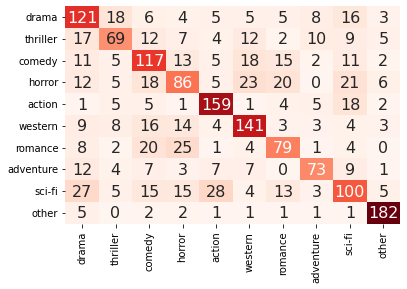

In [43]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(labels_test, predictions)

plotConfusionMatrix(cm, good_genres, good_genres)

C:\Users\andre\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


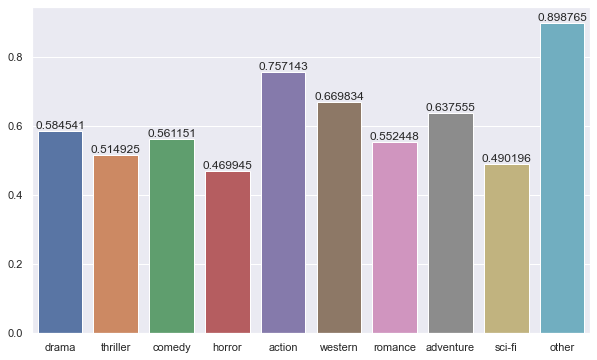

In [44]:
f1_scores = f1_score(labels_test, predictions, average=None)

sn.set(rc={'figure.figsize':(10,6)})
ax = sn.barplot(good_genres, f1_scores)

for i in ax.containers:
    ax.bar_label(i,)